# Graph-to-Hypergraph Path Lifting Tutorial

***
This notebook shows how to import a dataset, with the desired lifting, and how to run a neural network using the loaded data.

The notebook is divided into sections:

- [Loading the dataset](#loading-the-dataset) loads the config files for the data, creates a a dataset object and visualizes it.
- [Loading and applying the lifting](#loading-and-applying-the-lifting) the desired lifting tranformation is configured and applied.
- [Create and run a simplicial nn model](#create-and-run-a-simplicial-nn-model) defines a simple neural network and simply runs a forward pass to check that everything is working as expected.

***
***

Note that for simplicity the notebook is setup to use a simple graph. However, there is a set of available datasets that you can play with.

To switch to one of the available datasets, simply change the *dataset_name* variable to one of the following names:

* cocitation_cora
* cocitation_citeseer
* cocitation_pubmed
* MUTAG
* NCI1
* NCI109
* PROTEINS_TU
* AQSOL
* ZINC
***

### Imports and utilities

In [1]:
# With this cell any imported module is reloaded before each cell execution
%load_ext autoreload
%autoreload 2
import sys

sys.path.append("../..")
from modules.data.load.loaders import GraphLoader
from modules.data.preprocess.preprocessor import PreProcessor
from modules.utils.utils import (
    describe_data,
    load_dataset_config,
    load_model_config,
    load_transform_config,
)

## Loading the Dataset

Here we just need to specify the name of the available dataset that we want to load. First, the dataset config is read from the corresponding yaml file (located at `/configs/datasets/` directory), and then the data is loaded via the implemented `Loaders`.

In [2]:
dataset_name = "manual_dataset"
dataset_config = load_dataset_config(dataset_name)
loader = GraphLoader(dataset_config)


Dataset configuration for manual_dataset:

{'data_domain': 'graph',
 'data_type': 'toy_dataset',
 'data_name': 'manual',
 'data_dir': 'datasets/graph/toy_dataset',
 'num_features': 1,
 'num_classes': 2,
 'task': 'classification',
 'loss_type': 'cross_entropy',
 'monitor_metric': 'accuracy',
 'task_level': 'node'}



Dataset only contains 1 sample:


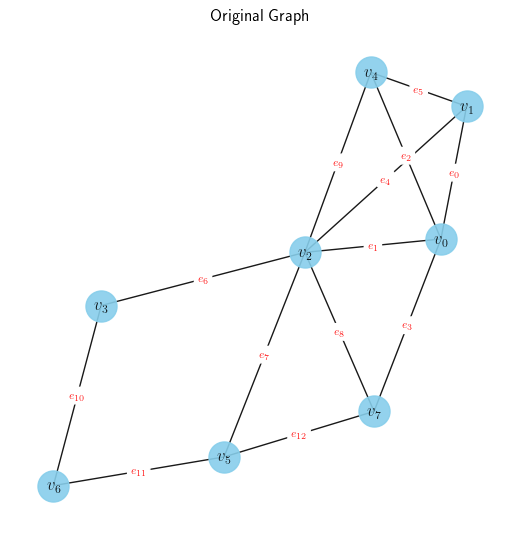

 - Graph with 8 vertices and 13 edges.
 - Features dimensions: [1, 0]
 - There are 0 isolated nodes.



In [3]:
dataset = loader.load()
describe_data(dataset)

## Loading and Applying the Lifting

In this section we will instantiate the lifting we want to apply to the data.

In [4]:
# Define transformation type and id
transform_type = "liftings"
# If the transform is a topological lifting, it should include both the type of the lifting and the identifier
transform_id = "graph2hypergraph/path_lifting"

# Read yaml file
transform_config = {
    "lifting": load_transform_config(transform_type, transform_id)
    # other transforms (e.g. data manipulations, feature liftings) can be added here
}
# add required arguments
transform_config["lifting"]["source_nodes"] = [1]
transform_config["lifting"]["target_nodes"] = [2]
transform_config["lifting"]["lengths"] = [2]

# select a value for optional argument
transform_config["lifting"]["include_smaller_paths"] = False


Transform configuration for graph2hypergraph/path_lifting:

{'transform_type': 'lifting',
 'transform_name': 'PathLifting',
 'feature_lifting': 'ProjectionSum'}


Transform parameters are the same, using existing data_dir: /home/pierrick/local/challenge-icml-2024/datasets/graph/toy_dataset/manual/lifting/480906646

Dataset only contains 1 sample:


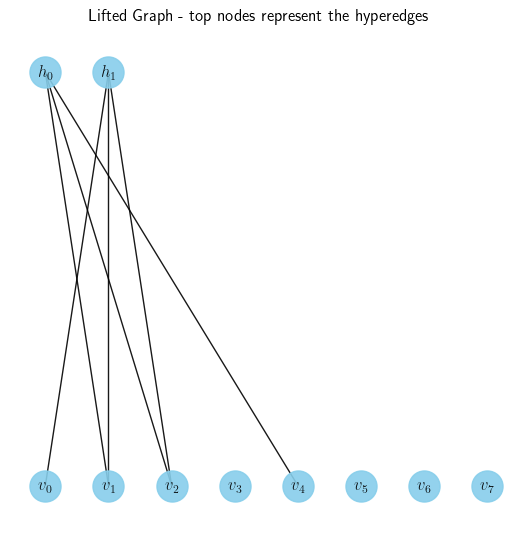

 - Hypergraph with 8 vertices and 2 hyperedges.
 - The nodes have feature dimensions 1.
 - The hyperedges have feature dimensions 1.



In [5]:
lifted_dataset = PreProcessor(dataset, transform_config, loader.data_dir)
describe_data(lifted_dataset)

## Create and Run an hypergraph NN Model

In this section a simple model is created to test that the used lifting works as intended. In this case the model uses the `incidence_hyperedges` matrix so the lifting should make sure to add it to the data.

In [6]:
from modules.models.hypergraph.unigcn import UniGCNModel

model_type = "hypergraph"
model_id = "unigcn"
model_config = load_model_config(model_type, model_id)

model = UniGCNModel(model_config, dataset_config)


Model configuration for hypergraph UNIGCN:

{'in_channels': None,
 'hidden_channels': 32,
 'out_channels': None,
 'n_layers': 2}


In [7]:
y_hat = model(lifted_dataset.get(0))